# 实验 v1.2

## 思路

使用【可解释方法】对实验数据【预处理】消除歧视样本，并【重新训练】，目的是提升【模型的公平性】


## 实验简介

1. 选择数据集 --> Adult
2. 选择训练模型 --> XGboost
3. 选择可解释模型 --> Shap
4. 选择不公平的数据样本 --> 选择敏感属性的 |shap_values| 的较大值
5. 选择 k1 个最不公平的数据样本 --> k1=1000 约占训练集的 5%
6. 构造 k2 个预处理样本呢 --> 令 k2=k1
7. 选择预处理策略 --> 更改敏感属性标签并加入训练集中
8. 选择公平性指标 --> dp 和 eo

## 如何优化

1. 如何使用可解释的输出来选择不公平的数据样本
2. 选择多少个样本（百分比）
3. 构造样本时，是保持不变（`k1=k2`）还是膨胀（`k1<k2`）
4. 如何选择预处理策略，直接加入后，X_train 是否要重新缩放
5. 如何选择公平性指标

## todo

1. 找出隐藏属性：是否有以下可能，训练一个分类器，专门分类敏感属性，然后看哪些属性对敏感属性的分类贡献较大
2. 找到隐藏属性后，按照排序，可以设置不同的权重（敏感属性的权重为0）
3. 重新训练


## 实验基本环境设置

In [126]:
# 导入依赖
import numpy as np
import pandas as pd
from rich import print

In [127]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

## 自定义函数

In [128]:
# 导入自定义函数
%load_ext autoreload
%autoreload 2
from utils.helper import fairness_metrics # 测试各种指标并输出图像
from utils.helper import test_model # 测试模型
from mydata.adult import X_train, y_train, X_test, y_test, sex, feature_index # 获得 数据集 测试集 和 测试集上的敏感属性
from utils.shap_helper import get_ext_train_comp_by_k


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 模型：逻辑回归

In [129]:
# 逻辑回归 - 训练
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# 逻辑回归 - 预测
y_pred = logreg.predict(X_test)

# 逻辑回归 - 指标
res_origin = fairness_metrics(y_test, y_pred, sex)

样本数[1.]         9769.000000
准确率[1.]            0.821681
精确率[1.]            0.710868
召回率[1.]            0.440865
FPR[0.]            0.057085
FNR[0.]            0.559135
F1 Score[1.]       0.544218
dtype: float64

人口平等 差异[0.] 0.17305965639298973

人口平等 比率[1.] 0.16808117698325414

机会均等 差异[0.] 0.2678519815463287

机会均等 比率[1.] 0.15100051877108894

## 模型：XGBoost + 处理过的训练集 + 对照组

In [130]:
percent_k = 0.05
top_k = int(len(X_train) * percent_k)
"选取的样本数量是", top_k

('选取的样本数量是', 1139)

In [131]:
import xgboost
def test_xgboost(X_train, y_train, X_test, y_test, sensitive_feature, desc=""):
    model = xgboost.XGBRegressor().fit(X_train, y_train)
    def model_pred_func(X_test):
        y_pred = model.predict(X_test)
        return np.where(y_pred > 0.5, 1, 0)
    result = test_model(model_pred_func, X_test, y_test, sensitive_feature, desc)
    return model, result

In [132]:
xgboost_orgin, res_origin = test_xgboost(X_train, y_train, X_test, y_test, sex, desc="原始组")

原始组

样本数[1.]         9769.000000
准确率[1.]            0.862422
精确率[1.]            0.768377
召回率[1.]            0.615939
FPR[0.]            0.059109
FNR[0.]            0.384061
F1 Score[1.]       0.683765
dtype: float64

人口平等 差异[0.] 0.16989595884523423

人口平等 比率[1.] 0.32250719180485066

机会均等 差异[0.] 0.08764799066199769

机会均等 比率[1.] 0.29597011190360795

In [133]:
(X_train_top, y_train_top), (X_train_rand, y_train_rand) = get_ext_train_comp_by_k(xgboost_orgin, X_train, y_train, feature_index, top_k)

In [134]:
xgboost_top, res_top = test_xgboost(X_train_top, y_train_top, X_test, y_test, sex, "SHAP优化组")

SHAP优化组

样本数[1.]         9769.000000
准确率[1.]            0.861194
精确率[1.]            0.761880
召回率[1.]            0.618482
FPR[0.]            0.061538
FNR[0.]            0.381518
F1 Score[1.]       0.682733
dtype: float64

人口平等 差异[0.] 0.17039110915922506

人口平等 比率[1.] 0.3275673645847877

机会均等 差异[0.] 0.07753737980101161

机会均等 比率[1.] 0.29636296361176107

In [135]:
xgboost_rand, res_rand = test_xgboost(X_train_rand, y_train_rand, X_test, y_test, sex, "SHAP优化组(对照)")

SHAP优化组(对照)

样本数[1.]         9769.000000
准确率[1.]            0.863343
精确率[1.]            0.767503
召回率[1.]            0.622721
FPR[0.]            0.060054
FNR[0.]            0.377279
F1 Score[1.]       0.687573
dtype: float64

人口平等 差异[0.] 0.16932005863165284

人口平等 比率[1.] 0.3305710921701584

机会均等 差异[0.] 0.06614974153743536

机会均等 比率[1.] 0.2904305643546099

In [136]:
import matplotlib.pyplot as plt

keys = res_origin.keys()
keys

dict_keys(['样本数[1.]', '准确率[1.]', '精确率[1.]', '召回率[1.]', 'FPR[0.]', 'FNR[0.]', 'F1 Score[1.]', '人口平等 差异[0.]', '人口平等 比率[1.]', '机会均等 差异[0.]', '机会均等 比率[1.]'])

In [137]:
tmp_d = {}
for key in keys:
    tmp_d[key] = [res_origin[key], res_top[key], res_rand[key]]
tmp_d

{'样本数[1.]': [9769.0, 9769.0, 9769.0],
 '准确率[1.]': [0.8624219469751254, 0.8611935715016891, 0.8633432285802027],
 '精确率[1.]': [0.7683765203595981, 0.7618798955613577, 0.7675026123301986],
 '召回率[1.]': [0.6159389571852479, 0.6184824077999153, 0.6227214921576939],
 'FPR[0.]': [0.05910931174089069, 0.06153846153846154, 0.06005398110661268],
 'FNR[0.]': [0.384061042814752, 0.3815175922000848, 0.37727850784230604],
 'F1 Score[1.]': [0.6837647058823529, 0.6827328029948527, 0.6875731336297684],
 '人口平等 差异[0.]': [0.16989595884523423,
  0.17039110915922506,
  0.16932005863165284],
 '人口平等 比率[1.]': [0.32250719180485066, 0.3275673645847877, 0.3305710921701584],
 '机会均等 差异[0.]': [0.08764799066199769,
  0.07753737980101161,
  0.06614974153743536],
 '机会均等 比率[1.]': [0.29597011190360795, 0.29636296361176107, 0.2904305643546099]}

In [138]:
# 使用DataFrame函数将字典转换为DataFrame对象
df = pd.DataFrame(tmp_d, index=["origin", "top-k", "rand-k"])
df


,样本数[1.],准确率[1.],精确率[1.],召回率[1.],FPR[0.],FNR[0.],F1 Score[1.],人口平等 差异[0.],人口平等 比率[1.],机会均等 差异[0.],机会均等 比率[1.]
origin,9769.0,0.862422,0.768377,0.615939,0.059109,0.384061,0.683765,0.169896,0.322507,0.087648,0.295970
top-k,9769.0,0.861194,0.761880,0.618482,0.061538,0.381518,0.682733,0.170391,0.327567,0.077537,0.296363
rand-k,9769.0,0.863343,0.767503,0.622721,0.060054,0.377279,0.687573,0.169320,0.330571,0.066150,0.290431


In [139]:
top_k

1139

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

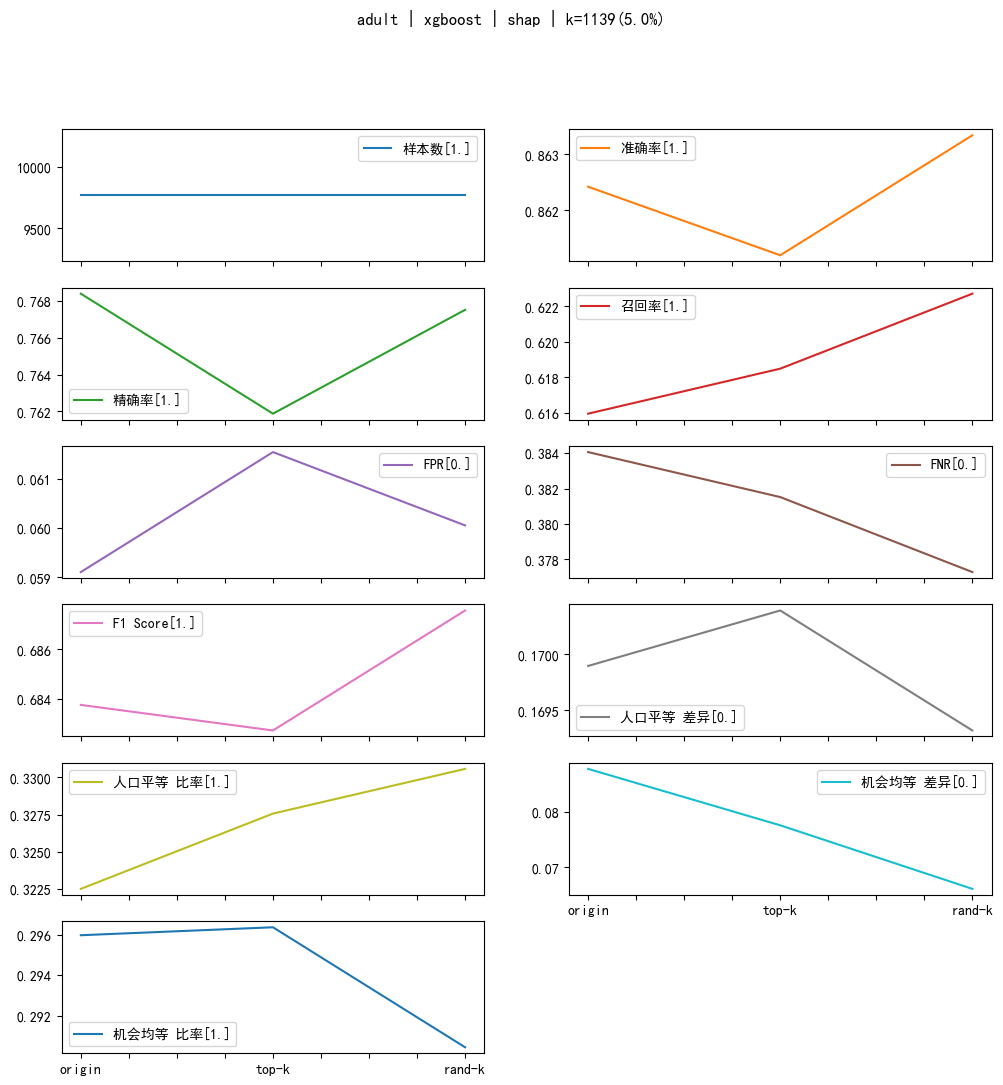

In [140]:
df.plot(
    title=f"adult | xgboost | shap | k={top_k}({percent_k*100}%)",
    subplots=True, 
    layout=(6,2), 
    figsize=(12, 12), 
    kind='line',
)